# Named entity recognition

Time to get our hands dirty with some analysis!

First, off choose a dataset that you want to work with. 

In [13]:
from pathlib import Path
import os
# These are your options from the webscrape
# uncomment one of the files to load it
# if you want to use the twitter data, uncomment the `data_dir` to the twitter data
# and uncomment one of the twitter files


data_dir = Path(os.path.abspath("")).parent / "795173" / "deduped"
file = "au.dk_deduped.ndjson"
# file = "kursuskatalog.au.dk_deduped.ndjson"
# file = "medarbejdere.au.dk_deduped.ndjson"
# file = "studerende.au.dk_deduped.ndjson"

# twitter data
# data_dir = Path(os.path.abspath("")).parent / "795173" / "au-twitter"
# file = "from_Aarhus_BSS_2007-01-01_2023-06-19.ndjson"
# file = "from_AarhusUni_2007-01-01_2023-06-19.ndjson"
# file = "from_AarhusUni_int_2007-01-01_2023-06-19.ndjson"
# file = "from_AUforsker_2007-01-01_2023-06-19.ndjson"
# file = "from_Nat_AU_Dean_2007-01-01_2023-06-19.ndjson"
# file = "from_StudyAarhusUni_2007-01-01_2023-06-19.ndjson"

data_path = data_dir / file
print(data_path)

/work/795173/deduped/au.dk_deduped.ndjson


In [14]:
import pandas as pd

data = pd.read_json(data_path, lines=True)

In [15]:
data

,url,text
0,https://au.dk/nyheder/browse/204,Samarbejde med forskere Samarbejde med studere...
1,https://au.dk/nyheder/browse/301,Samarbejde med forskere Samarbejde med studere...
2,https://au.dk/nyheder/artikel/ny-erkendelse-me...,Ny erkendelse medførte ændret estimat af kvæls...
3,https://au.dk/evu/generel-information,Samarbejde med forskere Samarbejde med studere...
4,https://au.dk/subuniversity/for-gymnasieelever...,Samarbejde med forskere Samarbejde med studere...
...,...,...
2168,https://au.dk/auchallenge/contact,Samarbejde med forskere Samarbejde med studere...
2169,https://au.dk/en/informationsecurity/annualpla...,Step 3: CHECK: Follow up Information Security ...
2170,https://au.dk/om/organisation/regelsamling/4/4...,Samarbejde med forskere Samarbejde med studere...
2171,https://au.dk/nyheder/artikel/skoldkoppevirus-...,Skoldkoppevirus livsfarlig ved nyopdaget immun...


## Getting started

To get you started, let's extract the most commonly occuring named entities across your chosen data file. 

We will do this by feeding text to a spacy pipeline, extracting the entities, and saving them. Lastly, we'll count how often each type of entity occurs, and which ones are the most commonly occuring.

### Challenge
**Reflection:**
* Should you clean the data before running this analysis? If so, what would you do?

Before we start, let's take a random sample of 150 websites to speed things up a bit.

In [25]:
data = data.sample(150, random_state=0)
data

,url,text
1261,https://au.dk/nyheder/artikel/hver-femte-dansk...,Samarbejde med forskere Samarbejde med studere...
78,https://au.dk/nyheder/artikel/brexit-how-will-...,Brexit – how will it affect you? Here you can ...
2158,https://au.dk/nyheder/artikel/topledere-fra-gy...,Samarbejde med forskere Samarbejde med studere...
826,https://au.dk/sfs/news/science-for-society-20,Samarbejde med forskere Samarbejde med studere...
1297,https://au.dk/en/about/uni,403 - siden er adgangsbegrænset / access is re...
...,...,...
932,https://au.dk/nyheder/artikel/flytning-i-to-et...,Samarbejde med forskere Samarbejde med studere...
625,https://au.dk/nyheder/browse/210,Samarbejde med forskere Samarbejde med studere...
697,https://au.dk/nyheder/artikel/aarhus-universit...,Samarbejde med forskere Samarbejde med studere...
1465,https://au.dk/nyheder/artikel/erhvervsdirektoe...,Samarbejde med forskere Samarbejde med studere...


In [26]:
import spacy

# load the spacy pipeline
nlp = spacy.load("da_core_news_lg")

# feed the 'text' column to the model
docs = nlp.pipe(data["text"])

# extract named entities
entities_and_types = []
for webpages in docs:
    for entity in webpages.ents:
        entities_and_types.append((entity.text, entity.label_))

# create a dataframe
entities_and_types_df = pd.DataFrame(entities_and_types, columns=["text", "entity_type"])

entities_and_types_df


,text,entity_type
0,Gymnasieportalen,LOC
1,Whistleblowerordning Profil Strategi AU,ORG
2,Bæredygtighed Campus 2.0,ORG
3,AU Job-,ORG
4,AU,ORG
...,...,...
5569,Brian Bech Nielsen,PER
5570,Jubilæumsfondens,ORG
5571,H.K.H. Dronning Margrethe II,PER
5572,Berit Eika,PER


There we go - we now have a dataframe of all the named entities in our sample of webpages along with their entity type. Luckily, they seem to make sense - Brian Bech Nielsen and Dronning Margrete are both people, and AU is an organization. A few cases seem to be artefacts of the scraping procedure that weren't cleaned entirely. For instance, "Whisteblowerordning Profil Strategi AU" looks like a header from a webpage rather than an organization. 

Let's do a bit of exploratory data analysis to get a feel for the entities in the data.

<Axes: ylabel='entity_type'>

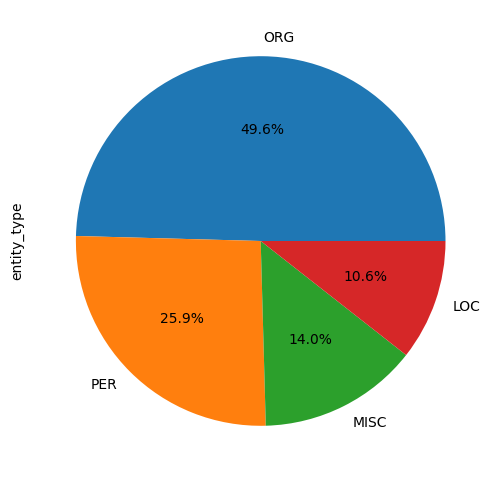

In [28]:
# plot proportion of each entity
entities_and_types_df["entity_type"].value_counts().plot(kind="pie", figsize=(6, 6), autopct='%1.1f%%')

In [22]:
# find 10 most common entities
entities_and_types_df["text"].value_counts().head(10)

Aarhus Universitet                         334
AU                                         294
Bæredygtighed Campus 2.0                   132
AU Job-                                    122
Gymnasieportalen                           121
Whistleblowerordning Profil Strategi AU    121
Aarhus Universitets                         77
danske                                      71
Danmark                                     57
Health                                      50
Name: text, dtype: int64

### Challenge
**Execution:**
* Rerun the analysis but with a different sample of the data. Are the results stable?
* Rerun the analysis with a different dataset. Are the results similar? 

**Reflection:**
* What use-cases do you see for named entity recognition in your organization? 


<details>
<summary>Some examples to get you thinking</summary></br>
Analysing named entities by webpage instead of across all pages. </br>
</br> Finding the entities a Twitter user engages with the most <br>
</br> Defining organization specific entities to extract <br>
</br> 
</details>

